# Machine Learning baseline

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from fastcore.basics import Path, AttrDict
import utils
import numpy as np
import pickle
import os
import sys

module_paths = [
    os.path.abspath(os.path.join('../..')),
    os.path.abspath(os.path.join('.')),
]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)


# This is used to import the evaluation script, not needed for training
import sys
sys.path.append('../') 
import evaluation
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
config = AttrDict(
    challenge_data_dir = Path('../../dataset/data_subset/'),
    # challenge_data_dir = Path('../../dataset/phase_1_v3/'),
    valid_ratio = .5,
    lag_steps = 0,
    tolerance= 6, # Default evaluation tolerance
)

In [3]:
# Define the list of feature columns
delta_column = "Delta_SemimajorAxis"
inclination_diff = "Inclination Diff"
sa_spike_column = "Semimajor Axis Spike"
inclination_direction = "Inclination Direction"
longitude_diff = "Longitude Diff"

feature_cols_ew = [
    "Eccentricity",
    "Semimajor Axis (m)",
    # "Inclination (deg)",
    "RAAN (deg)",
    "Argument of Periapsis (deg)",
    "True Anomaly (deg)",
    # "Latitude (deg)",
    "Longitude (deg)",
    "Altitude (m)",
    # "X (m)",
    # "Y (m)",
    # "Z (m)",
    # "Vx (m/s)",
    # "Vy (m/s)",
    # "Vz (m/s)",
    # delta_column,
    # inclination_diff,
    sa_spike_column,
    longitude_diff,
]

In [4]:
# Define the directory paths
train_data_dir = config.challenge_data_dir / "test"

# Load the ground truth data
ground_truth = pd.read_csv(config.challenge_data_dir / 'train_labels.csv')

# Apply the function to the ground truth data
data, updated_feature_cols = utils.tabularize_data(train_data_dir, feature_cols_ew, 
                                          ground_truth, lag_steps=config.lag_steps)

# For each ObjectID, show the first rows of the columns TimeIndex, ObjectID, EW, and NS
# data[['ObjectID', 'TimeIndex' , 'EW', 'NS']].groupby('ObjectID').head(2).head(10)
data.head()

,Timestamp,Eccentricity,Semimajor Axis (m),Inclination (deg),RAAN (deg),Argument of Periapsis (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (m),...,Vz (m/s),ObjectID,TimeIndex,Delta_SemimajorAxis,Semimajor Axis Spike,Inclination Diff,Inclination Direction,Longitude Diff,EW,NS
0,2022-09-01 00:00:00.000000Z,0.000298,4.232385e+07,0.155137,100.937023,3.916072,205.821557,0.003224,-29.177270,3.595709e+07,...,-7.212612,800,0,0.000000,-1,0.000000,-1,0.000000,SS-NK,SS-NK
1,2022-09-01 02:00:00.000000Z,0.009595,4.193313e+07,0.155117,100.927359,28.849592,210.681533,-0.016551,-29.475579,3.590000e+07,...,-4.162522,800,1,0.000000,-1,-0.000020,1,0.000000,SS-NK,SS-NK
2,2022-09-01 04:00:00.000000Z,0.009588,4.193376e+07,0.155086,100.881521,28.807209,240.704113,-0.031968,-29.623356,3.574942e+07,...,-0.001061,800,2,-390097.515161,-1,-0.000031,1,-0.446085,SS-NK,SS-NK
3,2022-09-01 06:00:00.000000Z,0.009594,4.193357e+07,0.155139,100.810516,28.899180,270.876695,-0.038786,-29.511937,3.554542e+07,...,4.216035,800,3,436.703174,-1,0.000053,1,-0.036359,SS-NK,SS-NK
4,2022-09-01 08:00:00.000000Z,0.009599,4.193282e+07,0.155307,100.748922,29.083972,301.248007,-0.034873,-29.099556,3.534306e+07,...,7.332078,800,4,-934.584356,-1,0.000168,1,0.523800,SS-NK,SS-NK


In [5]:
# Create a validation set without mixing the ObjectIDs
object_ids = data['ObjectID'].unique()
train_ids, valid_ids = train_test_split(object_ids, 
                                        test_size=config.valid_ratio,
                                        shuffle=True)

train_data = data[data['ObjectID'].isin(train_ids)].copy()
valid_data = data[data['ObjectID'].isin(valid_ids)].copy()

ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(train_ids)].copy()
ground_truth_valid = ground_truth[ground_truth['ObjectID'].isin(valid_ids)].copy()

# Count the number of objects in the training and validation sets
print('Number of objects in the training set:', len(train_data['ObjectID'].unique()))
print('Number of objects in the validation set:', len(valid_data['ObjectID'].unique()))

Number of objects in the training set: 50
Number of objects in the validation set: 50


Next we will make sure that there every label, both in the direction EW and NS,
is present both in the training and validation partitions

In [6]:
# Get the unique values of EW and NS in train and test data
train_EW = set(train_data['EW'].unique())
train_NS = set(train_data['NS'].unique())
valid_EW = set(valid_data['EW'].unique())
valid_NS = set(valid_data['NS'].unique())

# Get the values of EW and NS that are in test data but not in train data
missing_EW = valid_EW.difference(train_EW)
missing_NS = valid_NS.difference(train_NS)

# Check if all the values in EW are also present in NS
if not set(train_data['EW'].unique()).issubset(set(train_data['NS'].unique())):
    # Get the values of EW that are not present in NS
    missing_EW_NS = set(train_data['EW'].unique()).difference(
        set(train_data['NS'].unique())
    )
else:
    missing_EW_NS = None

# Print the missing values of EW and NS
print("Missing values of EW in test data:", missing_EW)
print("Missing values of NS in test data:", missing_NS)
print("Values of EW not present in NS:", missing_EW_NS)


Missing values of EW in test data: set()
Missing values of NS in test data: set()
Values of EW not present in NS: {'AD-NK'}


In [7]:
# # Convert categorical data to numerical data
# le_EW = LabelEncoder()
# le_NS = LabelEncoder()

# # Encode the 'EW' and 'NS' columns
# train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
# train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])
# valid_data['Predicted_EW'] = 'ES-ES'

# print("Columns encoded")

# # Define the Random Forest model for EW
# # model_EW = RandomForestClassifier(n_estimators=200, random_state=42)
# # Define the Random Forest model for NS
# model_EW = RandomForestClassifier(n_estimators=100)

# model_EW.fit(train_data[updated_feature_cols], train_data['EW_encoded'])

# Path('trained_model').mkdir(exist_ok=True)
# pickle.dump(model_EW, open('trained_model/model_EW_v3_new.pkl', 'wb'))
# pickle.dump(le_NS, open('trained_model/le_EW_v3_new.pkl', 'wb'))

In [8]:
import matplotlib.pyplot as plt
def plot_kbest_score(min, max, score_list, title):
    fig, ax = plt.subplots()
    x = np.arange(min, max+1)
    y = score_list

    ax.bar(x,y,width = 0.2)
    ax.set_xlabel('Number of features selected')
    ax.set_ylabel(title)
    ax.set_ylim(0,1.2)
    ax.set_xticks(np.arange(min,max+1))
    ax.set_xticklabels(np.arange(min, max+1), fontsize=12)

    for i, v in enumerate(y):
        plt.text(x=i+min, y=v+0.05, s=str(v), ha='center')

    plt.tight_layout()
    plt.show()

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import ns_id_Validator
import ns_ik_Validator
import ew_Validator
import ss_Validator

# TRAINED_MODEL_DIR = Path('./trained_model/')

# # Load the trained models (don't use the utils module, use pickle)
# model_EW = pickle.load(open(TRAINED_MODEL_DIR / 'model_EW_v3.pkl', 'rb'))
# le_EW = pickle.load(open(TRAINED_MODEL_DIR / 'le_EW_v3.pkl', 'rb'))
# model_NS = pickle.load(open(TRAINED_MODEL_DIR / 'model_NS_v3.pkl', 'rb'))
# le_NS = pickle.load(open(TRAINED_MODEL_DIR / 'le_NS_v3.pkl', 'rb'))

# Convert categorical data to numerical data
le_EW = LabelEncoder()
le_NS = LabelEncoder()

# Encode the 'EW' and 'NS' columns
train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])
valid_data['Predicted_NS'] = 'ES-ES'

print("Columns encoded")

# Define the Random Forest model for EW
# model_EW = RandomForestClassifier(n_estimators=200, random_state=42)
# Define the Random Forest model for NS
model_EW = RandomForestClassifier(n_estimators=200)

f2_score_list = []
recall_list = []
precision_list = []
ss_validator = ss_Validator.SS_Validator()
ew_validator = ew_Validator.EW_Validator()

k_min = 3
k_max = 8
print("KBest selection from: " + str(updated_feature_cols))
for k in range(k_min,k_max+1):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(train_data[updated_feature_cols], train_data['EW_encoded'])
    selector_mask = selector.get_support()
    print(train_data[updated_feature_cols].columns[selector_mask])

    sel_X_train = selector.transform(train_data[updated_feature_cols])
    sel_X_test = selector.transform(valid_data[updated_feature_cols])


    # Fit the model to the training data for NS
    model_EW.fit(sel_X_train, train_data['EW_encoded'])

    print("EW Classifier is Fit for k=" +str(k))

    # Make predictions on the training data for NS
    valid_data['Predicted_EW'] = le_EW.inverse_transform(
        model_EW.predict(sel_X_test)
    )

    test_results = utils.convert_classifier_output(valid_data)
    validated_results = ss_validator.apply_validator(test_results, valid_data)

    print("Before EW Validator:")
    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, validated_results, 
                                                tolerance=config.tolerance)
    precision, recall, f2, rmse = evaluator.score_EW(debug=True)
    # f2_score_list.append(round(f2, 3))
    print("F2 Score: " + str(round(f2, 3)))
    # recall_list.append(round(recall, 3))
    print("Recall: " + str(round(recall, 3)))
    # precision_list.append(round(precision,3))
    print("Precision: " + str(round(precision, 3)))
    print("RMSE: " + str(round(rmse, 3)))


    print("After EW Validator:")
    validated_results = ew_validator.apply_validator(validated_results, valid_data)

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, validated_results, 
                                                tolerance=config.tolerance)
    precision, recall, f2, rmse = evaluator.score_EW(debug=True)
    f2_score_list.append(round(f2, 3))
    print("F2 Score: " + str(round(f2, 3)))
    recall_list.append(round(recall, 3))
    print("Recall: " + str(round(recall, 3)))
    precision_list.append(round(precision,3))
    print("Precision: " + str(round(precision, 3)))
    print("RMSE: " + str(round(rmse, 3)))




Columns encoded
KBest selection from: ['Eccentricity', 'Semimajor Axis (m)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Longitude (deg)', 'Altitude (m)', 'Semimajor Axis Spike', 'Longitude Diff']
Index(['Eccentricity', 'Semimajor Axis (m)', 'Longitude (deg)'], dtype='object')
EW Classifier is Fit for k=3
Before EW Validator:
Total TPs: 149
Total FPs: 771
Total FNs: 10
Total Distances: [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Total Wrong Nodes: 35
Total Wrong Types: 13
Total Not Matched: 736
Total IK FP: 67
Total ID FP: 554
Total AD FP: 115
F2 Score: 0.479
Recall

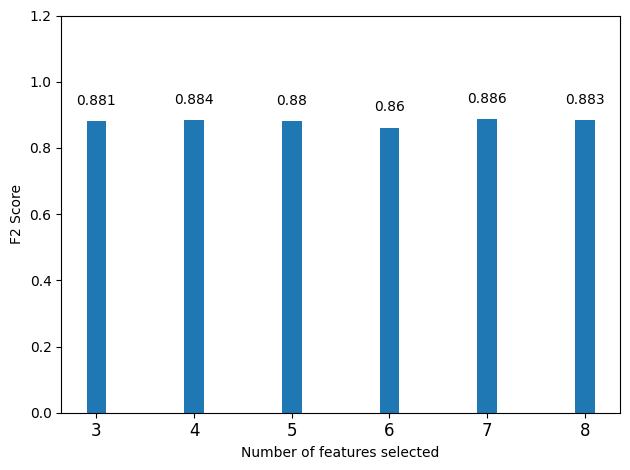

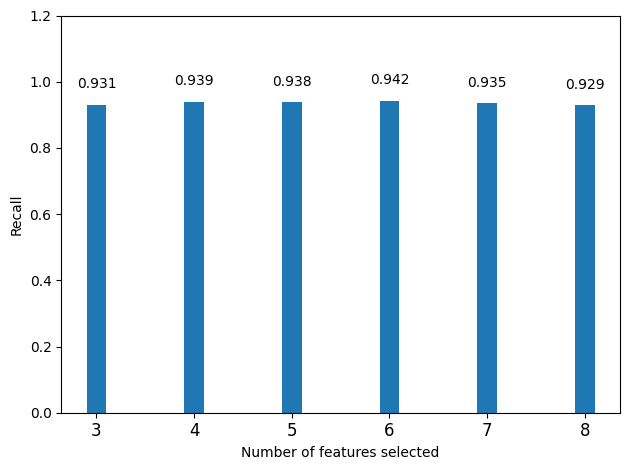

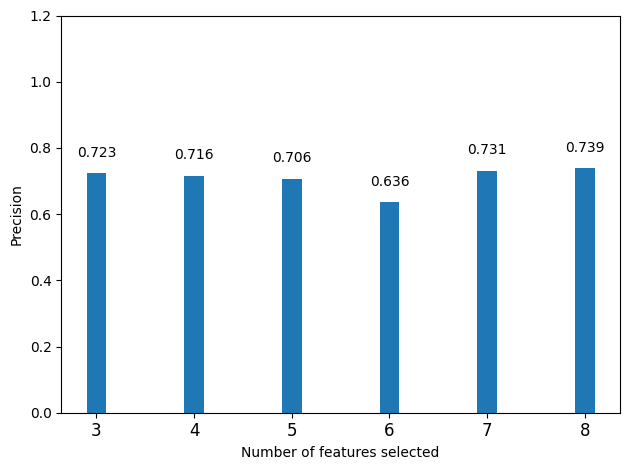

In [10]:
plot_kbest_score(k_min, k_max, f2_score_list, "F2 Score")
plot_kbest_score(k_min, k_max, recall_list, "Recall")
plot_kbest_score(k_min, k_max, precision_list, "Precision")

In [12]:
selector = SelectKBest(mutual_info_classif, k=7) # set the best k
selector.fit(train_data[updated_feature_cols], train_data['EW_encoded'])
selected_feature_mask = selector.get_support()

selected_features = train_data[updated_feature_cols].columns[selected_feature_mask]
selected_features



Index(['Eccentricity', 'Semimajor Axis (m)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)',
       'Longitude Diff'],
      dtype='object')

### We know the right features, now train for real ###

In [14]:
config = AttrDict(
    # challenge_data_dir = Path('../../dataset/data_subset/'),
    challenge_data_dir = Path('../../dataset/phase_1_v3/'),
    valid_ratio = .3,
    lag_steps = 0,
    tolerance= 6, # Default evaluation tolerance
)

longitude_diff = "Longitude Diff"

best_feature_cols_ew = [
    "Eccentricity",
    "Semimajor Axis (m)",
    "RAAN (deg)",
    "Argument of Periapsis (deg)",
    "Longitude (deg)",
    "Altitude (m)",
    longitude_diff,
]

train_data_dir = config.challenge_data_dir / "train"

# Load the ground truth data
ground_truth = pd.read_csv(config.challenge_data_dir / 'train_labels.csv')

# Apply the function to the ground truth data
data, updated_feature_cols = utils.tabularize_data(train_data_dir, best_feature_cols_ew, 
                                          ground_truth, lag_steps=config.lag_steps)

In [ ]:


# Create a validation set without mixing the ObjectIDs
object_ids = data['ObjectID'].unique()
train_ids, valid_ids = train_test_split(object_ids, 
                                        test_size=config.valid_ratio,
                                        shuffle=True)

train_data = data[data['ObjectID'].isin(train_ids)].copy()
valid_data = data[data['ObjectID'].isin(valid_ids)].copy()

ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(train_ids)].copy()
ground_truth_valid = ground_truth[ground_truth['ObjectID'].isin(valid_ids)].copy()

# Count the number of objects in the training and validation sets
print('Number of objects in the training set:', len(train_data['ObjectID'].unique()))
print('Number of objects in the validation set:', len(valid_data['ObjectID'].unique()))

# Convert categorical data to numerical data
le_EW = LabelEncoder()
le_NS = LabelEncoder()

# Encode the 'EW' and 'NS' columns
train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])
valid_data['Predicted_NS'] = 'ES-ES'

print("Columns encoded")

model_EW = RandomForestClassifier(n_estimators=200)
# Fit the model to the training data for NS
model_EW.fit(train_data[updated_feature_cols], train_data['EW_encoded'])

print("EW Classifier is Fit")

# Make predictions on the training data for NS
valid_data['Predicted_EW'] = le_EW.inverse_transform(
    model_EW.predict(valid_data[updated_feature_cols])
)

test_results = utils.convert_classifier_output(valid_data)
validated_results = ss_validator.apply_validator(test_results, valid_data)

print("Before EW Validator:")
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, validated_results, 
                                            tolerance=config.tolerance)
precision, recall, f2, rmse = evaluator.score_EW(debug=True)
# f2_score_list.append(round(f2, 3))
print("F2 Score: " + str(round(f2, 3)))
# recall_list.append(round(recall, 3))
print("Recall: " + str(round(recall, 3)))
# precision_list.append(round(precision,3))
print("Precision: " + str(round(precision, 3)))
print("RMSE: " + str(round(rmse, 3)))


print("After EW Validator:")
validated_results = ew_validator.apply_validator(validated_results, valid_data)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, validated_results, 
                                            tolerance=config.tolerance)
precision, recall, f2, rmse = evaluator.score_EW(debug=True)
f2_score_list.append(round(f2, 3))
print("F2 Score: " + str(round(f2, 3)))
recall_list.append(round(recall, 3))
print("Recall: " + str(round(recall, 3)))
precision_list.append(round(precision,3))
print("Precision: " + str(round(precision, 3)))
print("RMSE: " + str(round(rmse, 3)))

Path('trained_model').mkdir(exist_ok=True)
pickle.dump(model_EW, open('trained_model/model_EW_v3_new.pkl', 'wb'))
pickle.dump(le_EW, open('trained_model/le_EW_v3_new.pkl', 'wb'))